In [2]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import copy
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

%matplotlib inline

### Standardizing variables -- new age/sex/edu-normalized cognition tests

In [3]:
orig_folder ="../DATA/PROCESSED/"
new_folder = "../DATA/PROCESSED/standardized_demographics/"

if not os.path.isdir(new_folder):
    os.makedirs(new_folder)
    
y = 2
within = 3

# current year's features -- all standardization will be based on current year
cur_year_fname = "merged_kept_data_%iyrprev_within%i.csv"%(y,within)
CURRENT_YEAR = pd.read_csv(orig_folder + cur_year_fname)

# all years features - these will be used when we train multiple years of data
all_years_fname = "merged_data_all_%iyrprev_within%i.csv"%(y,within)
ALL_YEARS=pd.read_csv(orig_folder + all_years_fname)


# merge in non-temporal demographic info 
DEMOGRAPHICS = pd.read_csv("../DATA/raw/dataset_495_basic.csv")[["projid", "educ", "msex", "apoe_genotype", "race", "spanish"]].drop_duplicates()
DEMOGRAPHICS["spanish"] = 2-DEMOGRAPHICS["spanish"] 
ALL_YEARS.drop(["educ", "msex", "apoe_genotype", "race", "spanish"], axis=1, inplace=True)
CURRENT_YEAR.drop(["educ", "msex", "apoe_genotype", "race", "spanish"], axis=1, inplace=True)

ALL_YEARS = ALL_YEARS.merge(DEMOGRAPHICS, how="left", on="projid")
CURRENT_YEAR = CURRENT_YEAR.merge(DEMOGRAPHICS, how="left", on="projid")

# Standardize

In [6]:
# these are the variables we don't want to standardize (labels & identifiers)
carry_over_vars = ["projid", "study", "fu_year", "scaled_to", "onset_label_time", "onset_label_time_binary"]
excluded_variables = ["r_cistrk", "r_stroke", "lostcons", "chf_cum"]


# we'll standardize this copy of the df
new_ALL_YEARS = copy.copy(ALL_YEARS[carry_over_vars])
new_CURRENT_YEAR = copy.copy(CURRENT_YEAR[carry_over_vars])

In [7]:
# Continuous variables that need to be z-scored: 
cognitive_features = ['cts_animals', 'cts_bname', 'cts_catflu','cts_db', 'cts_delay', 'cts_df', 'cts_doperf', 'cts_ebdr', 'cts_ebmt',\
            'cts_fruits', 'cts_idea', 'cts_lopair', 'cts_mmse30', 'cts_nccrtd','cts_pmat', 'cts_pmsub', 'cts_read_nart', \
            'cts_sdmt', 'cts_story', 'cts_stroop_cname', 'cts_stroop_wread', 'cts_wli', 'cts_wlii', 'cts_wliii']
medical_features_sums = ['med_con_sum_cum', 'vasc_3dis_sum', 'vasc_risks_sum']
continuous_demographics = ['age_at_visit', 'educ']

# Composite variables: average over z-scores from cognitive tests ("cts_" variables)
composite_vars = {
    "cogn_ep": ["cts_wli", "cts_wlii", "cts_wliii", "cts_ebmt", "cts_ebdr",  "cts_story","cts_delay"],
    "cogn_po": ["cts_lopair", "cts_pmat"],
    "cogn_ps": ["cts_sdmt", "cts_nccrtd", "cts_stroop_cname", "cts_stroop_wread"],
    "cogn_se":  ["cts_bname", "cts_catflu", "cts_read_nart"],
    "cogn_wo": ["cts_db", "cts_df", "cts_doperf"],
    "cogn_global":  ["cts_wli", "cts_wlii", "cts_wliii", "cts_ebmt", "cts_ebdr",  "cts_story","cts_delay",
                     "cts_lopair", "cts_pmat", "cts_sdmt", "cts_nccrtd", "cts_stroop_cname", "cts_stroop_wread",
                     "cts_bname", "cts_catflu", "cts_read_nart", "cts_db", "cts_df", "cts_doperf"] }
    
# Binary variables: we leave these as is
binary = ['hypertension_cum', 'cancer_cum','diabetes_sr_rx', 'dm_cum', 'headinjrloc_cum', 'lostcons',\
                         'thyroid_cum', 'chf_cum', 'claudication_cum', 'heart_cum', 'stroke_cum', "msex", "spanish"]

# Categorical variables: need to be 1-hot encoded 
categorical = ['apoe_genotype', 'race', 'dcfdx']

In [8]:
# GET DUMMIES FOR CATEGORICAL VARS
temp = pd.concat((ALL_YEARS, CURRENT_YEAR))

for feat in categorical:
    dummies = pd.get_dummies(temp[feat])
    for col in dummies.columns:
        # if the column doesnt actually have any 1s for one of the datasets, don't add it
        if (np.nansum(dummies.iloc[len(ALL_YEARS):][col]) > 0) and np.nansum(dummies.iloc[:len(ALL_YEARS)][col]) > 0:
            new_ALL_YEARS[feat+"__"+str(col)] = dummies.iloc[:len(ALL_YEARS)][col]
            new_CURRENT_YEAR[feat+"__"+str(col)]= dummies.iloc[len(ALL_YEARS):][col]
            
    new_ALL_YEARS.at[ALL_YEARS[feat].isnull(), new_ALL_YEARS.columns.str.startswith(feat)]=np.nan
    new_CURRENT_YEAR.at[CURRENT_YEAR[feat].isnull(), new_CURRENT_YEAR.columns.str.startswith(feat)]=np.nan


### Changed: normalize cognitive features for age, sex, edu

Original normalization (just z-scores) for the other variables:

In [9]:
# get zscores for continuous vars
zscore_transforms = {}

for feat in medical_features_sums + continuous_demographics:
    if feat not in excluded_variables:
        zscore_transforms[feat] = (np.nanmean(CURRENT_YEAR[feat]), np.nanstd(CURRENT_YEAR[feat]))
    

for feat in zscore_transforms.keys():
    new_CURRENT_YEAR[feat] = (CURRENT_YEAR[feat]-zscore_transforms[feat][0])/zscore_transforms[feat][1]
    new_ALL_YEARS[feat] = (ALL_YEARS[feat]-zscore_transforms[feat][0])/zscore_transforms[feat][1]

In [10]:
#  Given that we're saving z-scores, we want to save a file to revert back to raw values:
#  un-standardize variables to get the original values:  x = (z*std)+mean
f = open(new_folder+"%iyrprev_within%i_mean_std.csv"%(y,within),"w")
f.write("variable, mean, std\n")
for key, val in zscore_transforms.items():
    f.write("%s, %f, %f\n"%(key, val[0], val[1]))

f.close()

New normalization for cognitive variables: regress out age,sex,edu (use residuals), and then get z-score of residual

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
print("missing vals:")
covariates = ['age_at_visit', 'educ', 'msex']
print(pd.isnull(CURRENT_YEAR[covariates]).mean(axis=0)/len(CURRENT_YEAR))

current_year_imp_covs =  CURRENT_YEAR[covariates].apply(lambda x: x.fillna(x.mean()),axis=0)
all_year_imp_covs = ALL_YEARS[covariates].apply(lambda x: x.fillna(x.mean()),axis=0)

missing vals:
age_at_visit    0.000000e+00
educ            1.448145e-07
msex            0.000000e+00
dtype: float64


In [22]:
coeffs = {}
pvals = {}
zscore_transforms_resid = {}
for feat in cognitive_features:
    clf = LinearRegression()
    notnull = ~pd.isnull(CURRENT_YEAR[feat])
    
    X2 = sm.add_constant(current_year_imp_covs[notnull])
    est = sm.OLS(CURRENT_YEAR[feat][notnull], X2)
    est2 = est.fit()

    coeffs[feat] = est2.params.values
    pvals[feat] = est2.pvalues.values

    resids = CURRENT_YEAR[feat] - est2.predict(sm.add_constant(current_year_imp_covs))
    resids_all_years = ALL_YEARS[feat] - est2.predict(sm.add_constant(all_year_imp_covs))
    zscore_transforms_resid[feat] = (np.nanmean(resids), np.nanstd(resids))
        

    new_CURRENT_YEAR[feat] = (resids-zscore_transforms_resid[feat][0])/zscore_transforms_resid[feat][1]
    new_ALL_YEARS[feat] = (resids_all_years-zscore_transforms_resid[feat][0])/zscore_transforms_resid[feat][1]

In [23]:
for comp in composite_vars:
    vars_to_check = np.setdiff1d(composite_vars[comp], excluded_variables)
    new_CURRENT_YEAR[comp] = new_CURRENT_YEAR[vars_to_check].mean(axis=1)
    new_ALL_YEARS[comp] = new_ALL_YEARS[vars_to_check].mean(axis=1)

In [24]:
for b in binary:
    if b not in excluded_variables:
        new_CURRENT_YEAR[b] = CURRENT_YEAR[b]
        new_ALL_YEARS[b] = ALL_YEARS[b]

In [25]:
print("VARS WITH MISSING VALUES:")
for df in [new_ALL_YEARS, new_CURRENT_YEAR]:
    print(len(df))
    for col in df.columns:
        if df[col].values.dtype != 'O':
            frac_missing = np.mean(np.isnan(df[col].values))
            if frac_missing > .1:
                print(col, frac_missing)

VARS WITH MISSING VALUES:
24565
onset_label_time 0.6294321188683085
onset_label_time_binary 0.6294321188683085
cts_pmat 0.11768776714838185
cts_stroop_cname 0.5438225117036434
cts_stroop_wread 0.5439853450030532
9103
cts_stroop_cname 0.6451719213446117
cts_stroop_wread 0.6457211908162145


In [26]:
new_ALL_YEARS.to_csv(new_folder + all_years_fname)
new_CURRENT_YEAR.to_csv(new_folder + cur_year_fname)

print("saved standardized data sets to: \n%s\n%s"%(new_folder + all_years_fname, new_folder + cur_year_fname))

saved standardized data sets to: 
../DATA/PROCESSED/standardized_demographics/merged_data_all_2yrprev_within3.csv
../DATA/PROCESSED/standardized_demographics/merged_kept_data_2yrprev_within3.csv


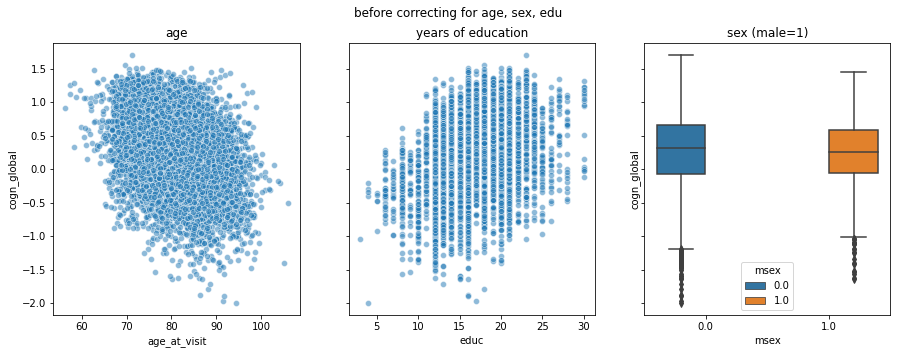

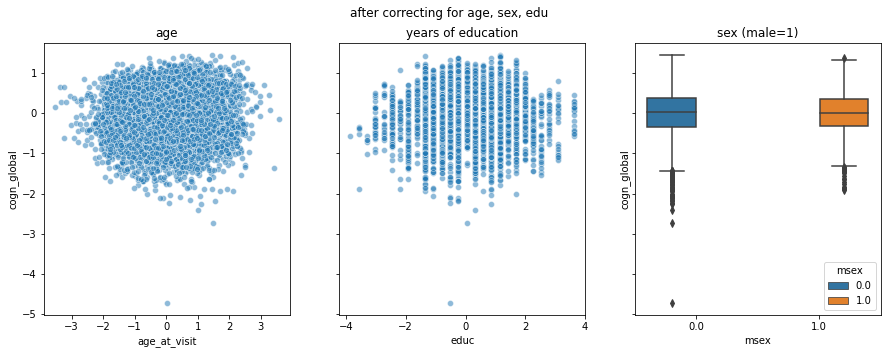

In [27]:
for cor_dset in ["before", "after"]:
    if cor_dset == "before":
        data_df = CURRENT_YEAR
    else:
        data_df = new_CURRENT_YEAR
    
    f,ax = plt.subplots(1,3,figsize=(15,5), sharey=True)
    
    sns.scatterplot(x = 'age_at_visit', y='cogn_global',  data=data_df, alpha=.5, ax=ax[0])
    ax[0].set_title("age")
    sns.scatterplot(x = 'educ', y='cogn_global',  data=data_df, alpha=.5, ax=ax[1])
    ax[1].set_title("years of education")
    sns.boxplot(x = 'msex', y='cogn_global',  hue='msex', data=data_df, ax=ax[2])
    ax[2].set_title("sex (male=1)")
    
    f.suptitle("%s correcting for age, sex, edu"%cor_dset)